15.12.2021

Load a bunch of UNet predictions in folder `trainings_validation` and compute some metrics, plots, etc.

Predictions are saved as:
`{training_name}_{epoch}_{video_id}_{class}.tif`

**Idea**: Use predictions to produce plots and tables to visualize the results.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas

In [2]:
import numpy as np
import glob
import os
import imageio

from scipy.ndimage.morphology import binary_dilation, binary_erosion
from sklearn.metrics import jaccard_score, f1_score

import pandas as pd
import matplotlib.pyplot as plt

import unet
from metrics_tools import (correspondences_precision_recall, 
                           Metrics, 
                           reduce_metrics, 
                           empty_marginal_frames,
                           process_spark_prediction,
                           process_puff_prediction,
                           process_wave_prediction,
                           write_videos_on_disk,
                           get_sparks_locations_from_mask
                          )

ModuleNotFoundError: No module named 'torch'

In [3]:
from scipy import optimize, spatial

In [ ]:
BASEDIR = os.path.abspath('')
BASEDIR

### Select predictions to load

In [ ]:
training_names = ["temporal_reduction",
                  "normalize_whole_video",
                  "reduce_first_layer_channels_64"
                  ]

epoch = 100000

### Configure input/output folder

In [ ]:
metrics_folder = "trainings_validation"

### Load predictions

In [ ]:
ys = {} # contains annotations for each training
sparks = {} # contains sparks for each training
puffs = {} # contains puffs for each training
waves = {} # contains waves for each training

for training_name in training_names:
    # Import .tif files as numpy array
    base_name = os.path.join(metrics_folder,training_name+"_"+str(epoch)+"_")
    
    ys_filenames = sorted(glob.glob(base_name+"*_ys.tif"))
    sparks_filenames = sorted(glob.glob(base_name+"*_sparks.tif"))
    puffs_filenames = sorted(glob.glob(base_name+"*_puffs.tif"))
    waves_filenames = sorted(glob.glob(base_name+"*_waves.tif"))
    
    training_ys = []
    training_sparks = []
    training_puffs = []
    training_waves = []
    
    for y,s,p,w in zip(ys_filenames,sparks_filenames,puffs_filenames,waves_filenames):
        training_ys.append(np.asarray(imageio.volread(y)).astype('int'))
        training_sparks.append(np.asarray(imageio.volread(s)))
        training_puffs.append(np.asarray(imageio.volread(p)))
        training_waves.append(np.asarray(imageio.volread(w)))
        
    ys[training_name] = training_ys
    sparks[training_name] = training_sparks
    puffs[training_name] = training_puffs
    waves[training_name] = training_waves        

## Jaccard index for puffs and waves
12.05.2021
Seguendo il consiglio di Pablo:
erosion & dilation delle annotations -> creazione di una exclusion region che viene ignorata dal supporto del Jaccard index

In [1]:
# Define function

def jaccard_score_exclusion_zone(ys,preds,exclusion_radius,sparks=False):
    
    # Compute intersection and union
    intersection = np.logical_and(ys, preds)
    union = np.logical_or(ys, preds)
    
    if exclusion_radius != 0:
        # Compute exclusion zone: 1 where Jaccard index has to be computed, 0 otherwise
        dilated = binary_dilation(ys, iterations=exclusion_radius)
        
        if not sparks:
            eroded = binary_erosion(ys, iterations=exclusion_radius)
            exclusion_mask = 1 - np.logical_xor(eroded,dilated)
        else:
            # Erosion is not computed for spark class
            exclusion_mask = 1 - np.logical_xor(ys,dilated)
    
        # Compute intersecion of exclusion mask with intersection and union
        intersection = np.logical_and(intersection, exclusion_mask)
        union = np.logical_and(union, exclusion_mask)
        
    #print("Pixels in intersection:", np.count_nonzero(intersection))
    #print("Pixels in union:", np.count_nonzero(union))
        
    if np.count_nonzero(union) != 0:
        iou = np.count_nonzero(intersection)/np.count_nonzero(union)
    else:
        iou = 1.
    
    return iou

### Compute metrics for sample video

In [8]:
# results for a sample movie in sample dataset
name = "temporal_reduction"
idx = 0

In [33]:
ignore_frames = 6

### Get binary preds and remove ignored frames

In [32]:
# get predictions
sparks_sample = sparks[name][idx]
puffs_sample = puffs[name][idx]
waves_sample = waves[name][idx]

In [34]:
t_detection = 0.5
min_radius_puffs = 4
min_radius_waves = 10

puffs_binary = process_puff_prediction(puffs_sample, 
                                       t_detection, 
                                       min_radius_puffs, 
                                       ignore_frames)

waves_binary = process_wave_prediction(waves_sample, 
                                       t_detection, 
                                       min_radius_waves, 
                                       ignore_frames)

### Get binary ys and remove ignored frames

In [35]:
# get binary ys
ys_sample = ys[name][idx]

ys_puffs_sample = np.where(ys_sample==3,1,0)
ys_waves_sample = np.where(ys_sample==2,1,0)

In [36]:
ys_puffs_sample = empty_marginal_frames(ys_puffs_sample, ignore_frames)
ys_waves_sample = empty_marginal_frames(ys_waves_sample, ignore_frames)

### Plot a sample frame

In [12]:
sparks_sample.shape, puffs_sample.shape, waves_sample.shape, ys_sample.shape

((125, 64, 512), (125, 64, 512), (125, 64, 512), (125, 64, 512))

In [23]:
sample_frame = 59

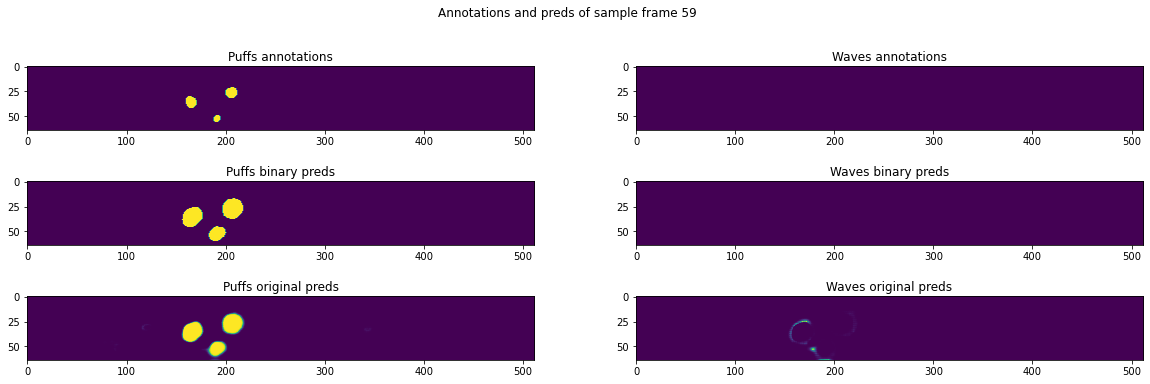

In [28]:
# Plot annotations and preds of sample frame

#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,6))
plt.suptitle(f"Annotations and preds of sample frame {sample_frame}", fontsize=12)


ax = plt.subplot(3,2,1)
ax.set_title("Puffs annotations")
plt.imshow(ys_puffs_sample[sample_frame])

ax = plt.subplot(3,2,2)
ax.set_title("Waves annotations")
plt.imshow(ys_waves_sample[sample_frame])

ax = plt.subplot(3,2,3)
ax.set_title("Puffs binary preds")
plt.imshow(puffs_binary[sample_frame])

ax = plt.subplot(3,2,4)
ax.set_title("Waves binary preds")
plt.imshow(waves_binary[sample_frame])

ax = plt.subplot(3,2,5)
ax.set_title("Puffs original preds")
plt.imshow(puffs_sample[sample_frame])

ax = plt.subplot(3,2,6)
ax.set_title("Waves original preds")
plt.imshow(waves_sample[sample_frame])


plt.show()

### Save sample binary preds on disk

In [29]:
imageio.volwrite(os.path.join(metrics_folder, "binary_preds_puffs.tif"), np.uint8(puffs_binary))
imageio.volwrite(os.path.join(metrics_folder, "binary_preds_waves.tif"), np.uint8(waves_binary))

### Save sample annotations on disk

In [30]:
imageio.volwrite(os.path.join(metrics_folder, "annotations_puffs.tif"), np.uint8(ys_puffs_sample))
imageio.volwrite(os.path.join(metrics_folder, "annotations_waves.tif"), np.uint8(ys_waves_sample))

### Compute Jaccard score (without exclusion zone)

In [60]:
iou_puffs = jaccard_score(ys_puffs_sample.ravel(), puffs_binary.ravel())
iou_waves = jaccard_score(ys_waves_sample.ravel(), waves_binary.ravel())

print(f"Jaccard score puffs: {iou_puffs}")
print(f"Jaccard score waves: {iou_waves}")

Jaccard score puffs: 0.20890103174317864
Jaccard score waves: 0.0


In [43]:
# Compute exclusion zone

exclusion_radius = 2

In [44]:
# Just for puffs
puffs_eroded = binary_erosion(ys_puffs_sample, iterations=exclusion_radius)
puffs_dilated = binary_dilation(ys_puffs_sample, iterations=exclusion_radius)

exclusion_mask = 1 - np.logical_xor(puffs_eroded, puffs_dilated)
# 1 where Jaccard index has to be computed, 0 otherwise

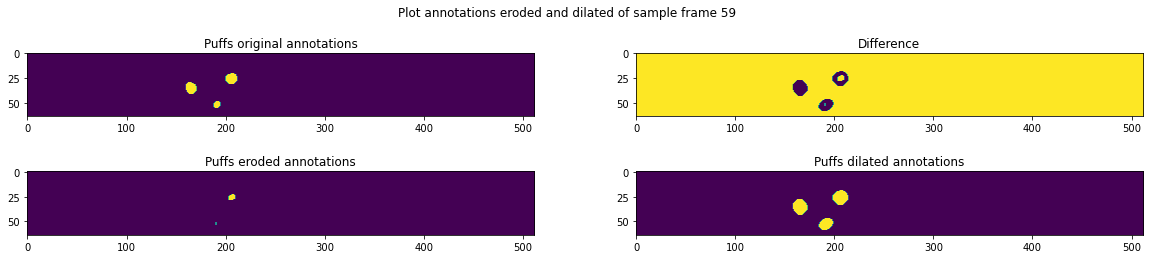

In [47]:
# Plot annotations eroded and dilated
#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,4))
plt.suptitle(f"Plot annotations eroded and dilated of sample frame {sample_frame}", fontsize=12)


ax = plt.subplot(2,2,1)
ax.set_title("Puffs original annotations")
plt.imshow(ys_puffs_sample[sample_frame])

ax = plt.subplot(2,2,2)
ax.set_title("Difference")
plt.imshow(1 - np.logical_xor(puffs_eroded,puffs_dilated)[sample_frame])

ax = plt.subplot(2,2,3)
ax.set_title("Puffs eroded annotations")
plt.imshow(puffs_eroded[sample_frame])

ax = plt.subplot(2,2,4)
ax.set_title("Puffs dilated annotations")
plt.imshow(puffs_dilated[sample_frame])


plt.show()

In [48]:
# Compute intersection and union of annotations with preds

intersection = np.logical_and(ys_puffs_sample, puffs_binary)
union = np.logical_or(ys_puffs_sample, puffs_binary)

# Compute intersection and union only in exclusion mask

intersection_mask = np.logical_and(intersection, exclusion_mask)
union_mask = np.logical_and(union, exclusion_mask)

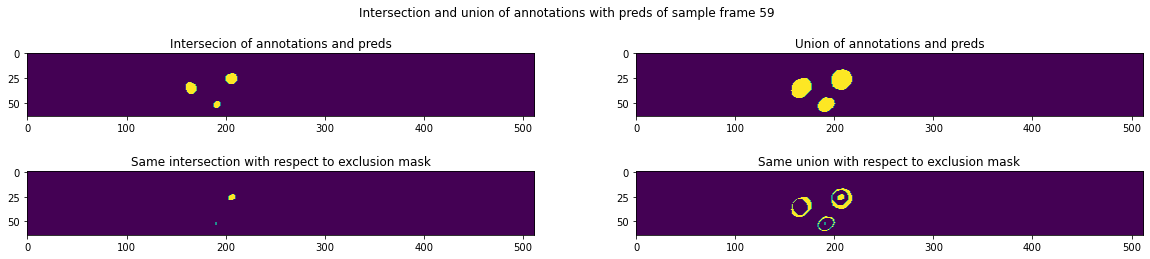

In [49]:
# Plot intersection and union
#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,4))
plt.suptitle(f"Intersection and union of annotations with preds of sample frame {sample_frame}", fontsize=12)


ax = plt.subplot(2,2,1)
ax.set_title("Intersecion of annotations and preds")
plt.imshow(intersection[sample_frame])

ax = plt.subplot(2,2,2)
ax.set_title("Union of annotations and preds")
plt.imshow(union[sample_frame])

ax = plt.subplot(2,2,3)
ax.set_title("Same intersection with respect to exclusion mask")
plt.imshow(intersection_mask[sample_frame])

ax = plt.subplot(2,2,4)
ax.set_title("Same union with respect to exclusion mask")
plt.imshow(union_mask[sample_frame])


plt.show()

In [50]:
# Compute Jaccard index

print(f"Pixels in intersection: {np.count_nonzero(intersection_mask)}")
print(f"Pixels in union: {np.count_nonzero(union_mask)}")

new_iou_puffs = np.count_nonzero(intersection_mask)/np.count_nonzero(union_mask)

print(f"IoU wrt to wave class: {new_iou_puffs}")

Pixels in intersection: 2397
Pixels in union: 29495
IoU wrt to wave class: 0.08126801152737752


In [69]:
new_iou_puffs = jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, exclusion_radius)
new_iou_waves = jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, exclusion_radius)

Pixels in intersection: 2397
Pixels in union: 29495
Pixels in intersection: 0
Pixels in union: 0


In [70]:
print(new_iou_puffs)
print(new_iou_waves)

0.08126801152737752
1.0


### Jaccard index for sparks

In [73]:
# get sparks annotations
ys_sparks_sample = np.where(ys_sample==1,1,0)

# get sparks predictions
t_detection_sparks = 0.9
min_radius_sparks = 3
sparks_binary = (process_spark_prediction(sparks_sample, 
                                          t_detection=t_detection_sparks,
                                          min_radius=min_radius_sparks,
                                          ignore_frames=ignore_frames,
                                          return_clean_pred=True)) != 0 

### Comparison with original implementation (when radius = 0)

In [76]:
print("Jaccard index with new method:")
print(f"Puffs: {jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, 0)}")
print(f"Waves: {jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, 0)}")
print(f"Sparks: {jaccard_score_exclusion_zone(ys_sparks_sample, sparks_binary, 0, sparks=True)}")
print()
print("Jaccard index with sklearn metrics method")
print(f"Puffs: {jaccard_score(ys_puffs_sample.ravel(), puffs_binary.ravel())}")
print(f"Waves: {jaccard_score(ys_waves_sample.ravel(), waves_binary.ravel())}")
print(f"Sparks: {jaccard_score(ys_sparks_sample.ravel(), sparks_binary.ravel())}")

Jaccard index with new method:
Puffs: 0.20890103174317864
Waves: 1.0
Sparks: 0.04723618090452261

Jaccard index with sklearn metrics method
Puffs: 0.20890103174317864
Waves: 0.0
Sparks: 0.04723618090452261


### Plot IoU with respect to different exclusion radius

In [77]:
exclusion_radius_list = [0,1,2,3,4,5,6,7,8,9,10]

# puffs
ious_puffs = []
for radius in exclusion_radius_list:
    ious_puffs.append(jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, radius))
    
# waves
ious_waves = []
for radius in exclusion_radius_list:
    ious_waves.append(jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, radius))
    
# sparks
ious_sparks = []
for radius in exclusion_radius_list:
    ious_sparks.append(jaccard_score_exclusion_zone(ys_sparks_sample, sparks_binary, radius, sparks=True))

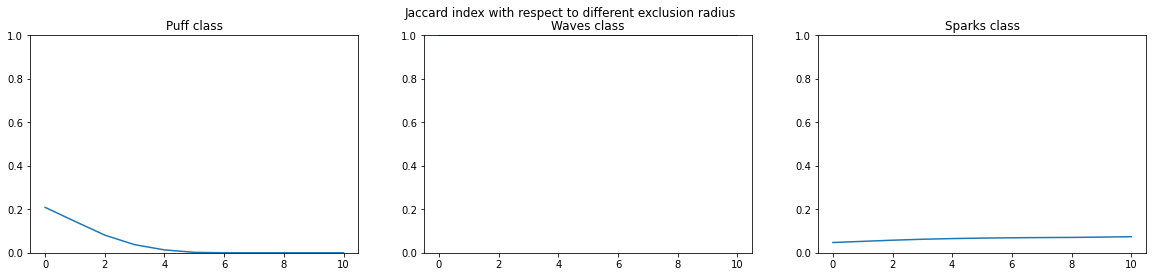

In [78]:
# Plot Jaccard index wrt different exclusion radius
#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,4))
plt.suptitle(f"Jaccard index with respect to different exclusion radius", fontsize=12)


ax = plt.subplot(1,3,1)
ax.set_title("Puff class")
plt.ylim([0, 1])
plt.plot(exclusion_radius_list, ious_puffs)

ax = plt.subplot(1,3,2)
ax.set_title("Waves class")
plt.ylim([0, 1])
plt.plot(exclusion_radius_list, ious_waves)

ax = plt.subplot(1,3,3)
ax.set_title("Sparks class")
plt.ylim([0, 1])
plt.plot(exclusion_radius_list, ious_sparks)


plt.show()

In [79]:
print(f"IoUs puffs: {ious_puffs}")
print(f"IoUs puffs: {ious_waves}")
print(f"IoUs puffs: {ious_sparks}")

IoUs puffs: [0.20890103174317864, 0.14459408432976714, 0.08126801152737752, 0.037353441136730156, 0.013306755737528283, 0.0021321961620469083, 7.474400179385604e-05, 0.0, 0.0, 0.0, 0.0]
IoUs puffs: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
IoUs puffs: [0.04723618090452261, 0.05264336917562724, 0.05791030064070971, 0.06230116648992577, 0.06536856745479833, 0.06762589928057554, 0.06909732431637754, 0.07004470938897168, 0.07078313253012049, 0.07219662058371736, 0.07413249211356467]


## Evaluate all trainings on all videos

In [81]:
# parameters
ignore_frames = 6

t_detection = 0.5
t_detection_sparks = 0.9

min_radius_puffs = 4
min_radius_waves = 10
min_radius_sparks = 3

exclusion_radius_list = [0,1,2,3,4,5,6,7,8,9,10]

# each dictionary contains, for every training name, a list of IoU scores averaged on all videos for all exclusion radius
ious_sparks_all_trainings = {} # num trainings x num video x num exclusion radius
ious_puffs_all_trainings = {}
ious_waves_all_trainings = {}

for training_name in training_names:
    # get predictions
    sparks_training = sparks[training_name]
    puffs_training = puffs[training_name]
    waves_training = waves[training_name]
    
    # get annotations
    ys_training = ys[training_name]
    
    ious_puffs_all_video = []
    ious_waves_all_video = []
    ious_sparks_all_video = []
    
    for sparks_sample, puffs_sample, waves_sample, ys_sample in zip(sparks_training, puffs_training, waves_training, ys_training):
        # get binary predictions and remove ignored frames
        puffs_binary = process_puff_prediction(puffs_sample, 
                                               t_detection, 
                                               min_radius_puffs, 
                                               ignore_frames)
        waves_binary = process_wave_prediction(waves_sample, 
                                               t_detection, 
                                               min_radius_waves, 
                                               ignore_frames)
        sparks_binary = (process_spark_prediction(sparks_sample, 
                                                  t_detection=t_detection_sparks,
                                                  min_radius=min_radius_sparks,
                                                  ignore_frames=ignore_frames,
                                                  return_clean_pred=True)) != 0 
        
        # get binary ys and remove ignored frames
        ys_sparks_sample = empty_marginal_frames(np.where(ys_sample==1,1,0), ignore_frames)
        ys_puffs_sample = empty_marginal_frames(np.where(ys_sample==3,1,0), ignore_frames)
        ys_waves_sample = empty_marginal_frames(np.where(ys_sample==2,1,0), ignore_frames)
        
        
        # compute IoU for some exclusion radius values
        # puffs
        ious_puffs = []
        for radius in exclusion_radius_list:
            ious_puffs.append(jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, radius))
            
        ious_puffs_all_video.append(ious_puffs)

        # waves
        ious_waves = []
        for radius in exclusion_radius_list:
            ious_waves.append(jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, radius))
            
        ious_waves_all_video.append(ious_waves)

        # sparks
        ious_sparks = []
        for radius in exclusion_radius_list:
            ious_sparks.append(jaccard_score_exclusion_zone(ys_sparks_sample, sparks_binary, radius, sparks=True))
            
        ious_sparks_all_video.append(ious_sparks)
        
    ious_sparks_all_trainings[training_name] = ious_sparks_all_video
    ious_puffs_all_trainings[training_name] = ious_puffs_all_video
    ious_waves_all_trainings[training_name] = ious_waves_all_video

### Compute average along videos of IoU for each exclusion radius for each training name

In [95]:
ious_sparks_avg = {} # num training x num exclusion radius
ious_puffs_avg = {}
ious_waves_avg = {}

for training_name in training_names:
    num_videos = len(ious_sparks_all_trainings[name])
    
    ious_sparks_all_video = ious_sparks_all_trainings[training_name] # num videos x num exclusion radius
    ious_puffs_all_video = ious_puffs_all_trainings[training_name] 
    ious_waves_all_video = ious_waves_all_trainings[training_name] 
    
    ious_sparks_avg[training_name] = np.sum(np.asarray(ious_sparks_all_video),0)/num_videos
    ious_puffs_avg[training_name] = np.sum(np.asarray(ious_puffs_all_video),0)/num_videos
    ious_waves_avg[training_name] = np.sum(np.asarray(ious_waves_all_video),0)/num_videos

### Plot average IoU for all trainings and all classes wrt to exclusion radius

In [175]:
cols = pd.Index(exclusion_radius_list, name='Exclusion radius')
classes = ['Sparks', 'Puffs', 'Waves']
rows = pd.MultiIndex.from_product([classes, training_names], names=['Class', 'Training name'])

data = [*ious_sparks_avg.values(),
        *ious_puffs_avg.values(),
        *ious_waves_avg.values()
       ]

df = pd.DataFrame(data, rows, cols)

In [176]:
print(df)

Exclusion radius                             0         1         2         3   \
Class  Training name                                                            
Sparks temporal_reduction              0.013768  0.014982  0.016290  0.017401   
       normalize_whole_video           0.031568  0.032936  0.034666  0.036525   
       reduce_first_layer_channels_64  0.029136  0.030522  0.032408  0.034685   
Puffs  temporal_reduction              0.192458  0.195439  0.193408  0.193291   
       normalize_whole_video           0.115739  0.111510  0.106234  0.100310   
       reduce_first_layer_channels_64  0.142404  0.142853  0.140523  0.136385   
Waves  temporal_reduction              0.789796  0.792832  0.793802  0.793395   
       normalize_whole_video           0.333221  0.332684  0.332057  0.331325   
       reduce_first_layer_channels_64  0.346099  0.346766  0.347263  0.347615   

Exclusion radius                             4         5         6         7   \
Class  Training name                                                            
Sparks temporal_reduction              0.018238  0.018829  0.019243  0.019532   
       normalize_whole_video           0.038287  0.039816  0.041090  0.042134   
       reduce_first_layer_channels_64  0.037097  0.039381  0.041365  0.042916   
Puffs  temporal_reduction              0.195703  0.198430  0.201271  0.206326   
       normalize_whole_video           0.093821  0.086915  0.079970  0.073271   
       reduce_first_layer_channels_64  0.130458  0.123084  0.114858  0.105948   
Waves  temporal_reduction              0.791445  0.787661  0.782425  0.776031   
       normalize_whole_video           0.330498  0.329598  0.328631  0.327590   
       reduce_first_layer_channels_64  0.347829  0.347935  0.347950  0.347909   

Exclusion radius                             8         9         10  
Class  Training name                                                 
Sparks temporal_reduction              0.019814  0.020218  0.020707  
       normalize_whole_video           0.042949  0.043594  0.044167  
       reduce_first_layer_channels_64  0.044056  0.044860  0.045415  
Puffs  temporal_reduction              0.212674  0.216554  0.215885  
       normalize_whole_video           0.066499  0.059417  0.051891  
       reduce_first_layer_channels_64  0.096583  0.086589  0.075681  
Waves  temporal_reduction              0.769463  0.764446  0.761096  
       normalize_whole_video           0.326451  0.325204  0.323827  
       reduce_first_layer_channels_64  0.347788  0.347567  0.347177

Text(0.5, 0, 'Exclusion radius')

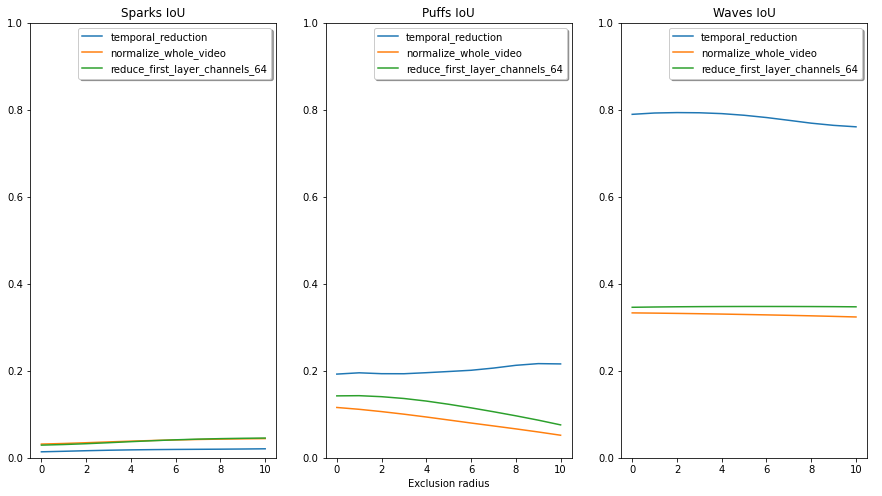

In [169]:
fig, axs = plt.subplots(1, 3, sharex=True, figsize=(15,8))
fig.add_subplot(111, frameon=False)
axs[0].plot(exclusion_radius_list, ious_sparks_avg[training_names[0]], label=training_names[0])
axs[0].plot(exclusion_radius_list, ious_sparks_avg[training_names[1]], label=training_names[1])
axs[0].plot(exclusion_radius_list, ious_sparks_avg[training_names[2]], label=training_names[2])
           
axs[0].set_title('Sparks IoU')
axs[0].set_ylim([0,1])
axs[0].legend(shadow=True, fancybox=True)

axs[1].plot(exclusion_radius_list, ious_puffs_avg[training_names[0]], label=training_names[0])
axs[1].plot(exclusion_radius_list, ious_puffs_avg[training_names[1]], label=training_names[1])
axs[1].plot(exclusion_radius_list, ious_puffs_avg[training_names[2]], label=training_names[2])

axs[1].set_title('Puffs IoU')
axs[1].set_ylim([0,1])
axs[1].legend(shadow=True, fancybox=True)

axs[2].plot(exclusion_radius_list, ious_waves_avg[training_names[0]], label=training_names[0])
axs[2].plot(exclusion_radius_list, ious_waves_avg[training_names[1]], label=training_names[1])
axs[2].plot(exclusion_radius_list, ious_waves_avg[training_names[2]], label=training_names[2])

axs[2].set_title('Waves IoU')
axs[2].set_ylim([0,1])
axs[2].legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Exclusion radius")

### Sparks metrics (TODO)

In [4]:
# open sparks predictions
sparks_name = training_name+"_"+str(epoch)+"_"+idx+"_sparks"+test_string+".tif"
sparks = np.asarray(imageio.volread(os.path.join(training_folder,sparks_name)))

In [5]:
# get sparks annotated locations
annotations_sparks_loc = get_sparks_locations_from_mask(annotations, ignore_frames)

In [6]:
print("annotated sparks:")
print(*annotations_sparks_loc)

annotated sparks:
[317  35 179] [393  36 226] [473   5 318] [474  36 295] [548  14 205] [954  28 154]


In [7]:
# get sparks predicted locations
min_radius = 3 # minimal 'radius' of a valid spark
t_detection = 0.9 # threshold on spark preds to extract events

preds_sparks_loc = process_spark_prediction(sparks, 
                                        t_detection=t_detection, 
                                        min_radius=min_radius,
                                        ignore_frames=ignore_frames)

In [8]:
print("predicted sparks:")
print(*preds_sparks_loc)

predicted sparks:
[367  35 221] [393  36 225] [486  26 182] [540  26 143] [548  14 205] [908  18 138] [953  28 153]


In [9]:
# compute precision and recall for sparks
match_distance = 5
metrics = Metrics(*correspondences_precision_recall(annotations_sparks_loc, 
                                                    preds_sparks_loc, 
                                                    match_distance=match_distance))


In [10]:
metrics

Metrics(precision=0.42857142857142855, recall=0.5, tp=3, tp_fp=7, tp_fn=6)

In [1]:
! echo $CONDA_PREFIX

/storage/homefs/pd19x428/anaconda3/envs/sparks


In [3]:
conda list

# packages in environment at /software.el7/software/Anaconda3/2021.11-foss-2021a:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0            py39h06a4308_0  
_libgcc_mutex             0.1                        main  
_openmp_mutex             4.5                       1_gnu  
alabaster                 0.7.12             pyhd3eb1b0_0  
anaconda                  2021.11                  py39_0  
anaconda-client           1.9.0            py39h06a4308_0  
anaconda-navigator        2.1.1                    py39_0  
anaconda-project          0.10.1             pyhd3eb1b0_0  
anyio                     2.2.0            py39h06a4308_1  
appdirs                   1.4.4              pyhd3eb1b0_0  
argh                      0.26.2           py39h06a4308_0  
argon2-cffi               20.1.0           py39h27cfd23_1  
arrow                     0.13.1           py39h06a4308_0  
asn1crypto                1.4.0                      py_0  
astroid  

In [8]:
conda update conda

Solving environment: done

## Package Plan ##

  environment location: /software.el7/software/Anaconda3/2021.11-foss-2021a

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.11.0               |   py39h06a4308_0        14.4 MB
    ------------------------------------------------------------
                                           Total:        14.4 MB

The following packages will be UPDATED:

  conda                               4.10.3-py39h06a4308_0 --> 4.11.0-py39h06a4308_0



conda-4.11.0         | 14.4 MB   | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: failed

EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: /software.el7/software/Anaconda3/2021.11-foss-2021a
  uid: 37152
  gid: 1015



Note: you may need

In [4]:
conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /software.el7/software/Anaconda3/2021.11-foss-2021a

  added / updated specs:
    - cudatoolkit=11.3
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    nettle-3.7.3               |       hbbd107a_1         809 KB
    openh264-2.1.0             |       hd408876_0         722 KB
    pytorch-mutex-1.0          |             cuda           3 KB  pytorch
    ------------------------------------------------------------
                                           Total:         1.5 MB

The following NEW packages will be INSTALLED:

  cudatoolkit        pkgs/main/linux-64::cudatoolkit-11.3.1-h2bc3f7f_2
  ffmpeg             pytorch/linux-64::ffmpeg-4.3-hf484d3e_0
  gnutls             pkgs/main/linux-64::gnutls-3.6.15-he1e5248_0
  lame               pkgs/main/linux-64::lame-3.100-h